<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Classification Metrics: The ROC curve and the AUC
              
</p>
</div>

Data Science Cohort Live NYC Feb 2022
<p>Phase 3: Topic 26</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#### What is the issue?

- Related to (basically the same as) concerns around Neyman-Pearson testing

<img src = "Images/neyman_pearson.png" />

<img src = "Images/neyman_small.png" width = 300 />

- $\alpha$ is the false positive rate (reject null when null is true)
- $\beta$ is false negative rate (accept null when null is false)

- Dependent on $t_{crit}$ OR:
    - the significance level $\alpha$
    - the probability **threshold**

#### Obvious connection
- Hypothesis testing
- Probabilistic classification 

$\alpha$ and $\beta$ depends on:
- significance level
- the structure of the hypothesis test (distribution, type of test, etc.)
- the data (sample size, etc.)

Precision, recall, F-score depends on:
- threshold
- structure of model (type of model, hyperparameters)
- the data

#### Understanding model quality

Want to systematically understand:
- how changing threshold affects:
    - true positive/false positive rate
    - precision/recall 

A nice applet. Let' play with it:

http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Tuning the tolerance (the significance level):
- Traces out a curve in (true positive rate, false positive rate) space.

**Reciever Operator Characteristic**

<img src = "Images/roc_curve.png" />

Reciever operator characteristic (ROC) curve:
- Name comes from early days of radar detection.
- WW2 operators detecting enemy airplanes.

<center><img src = "Images/azm_zero.jpeg" width = 500/></center>
<center> Detecting the Japanese AZM Zero Fighter </center>


#### The ROC curve in scikit-learn

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

Load in the heart disease dataset.

In [4]:
hd_data = pd.read_csv('Data/heart.csv')
hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
# Separate data into feature and target DataFrames
hd_X = hd_data.drop('target', axis=1)
hd_y = hd_data['target']

hd_X.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [6]:
hd_y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [7]:
hd_y.value_counts() # 1 = heart disease

1    165
0    138
Name: target, dtype: int64

In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(hd_X, hd_y, test_size=.25,
                                                   random_state=1)
# Scale the data for modeling
hd_scaler = StandardScaler()
hd_scaler.fit(X_train)
X_train_sc = hd_scaler.transform(X_train)
X_test_sc = hd_scaler.transform(X_test)

# Train a logistic regresssion model with the train data
hd_model = LogisticRegression(random_state=42)
hd_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

In [9]:
y_pred = hd_model.predict(X_test_sc)
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

Scikit-learn assumes a probability threshold of 0.5 on binary classification.

<center><img src = "Images/sigmoid.png" /></center>

#### The underlying predicted probability of each class given data observation
- the .predict_proba() function

In [10]:
y_prob = hd_model.predict_proba(X_test_sc)
y_prob[:5]

array([[0.99583439, 0.00416561],
       [0.2234686 , 0.7765314 ],
       [0.91939062, 0.08060938],
       [0.99402865, 0.00597135],
       [0.97047813, 0.02952187]])

Get a 2D array:
- [P(class 0|x), P(class 1|x)] for each x in test set.

In principle:
- Can change threshold cutoff to assign to given positive class
- Track changes in metrics
    - True positive/false positive rate

- True positive rate: $$ \frac{TP}{TP+FN}$$

Rate of correctly rejecting null 

- False positive rate: $$ \frac{FP}{FP+TN}$$

Rate of falsely rejecting null (Type I error)

Given test/validation set:
- calculate these metrics

#### roc_curve(y_true, y_score)
- first argument: test values
- second argument: probability of positive class    

- list of false positive rate (fpr)
- list of true positive rate (tpr)
- list of "thresholds" each fpr, tpr was calculated at:
    - roughly: value of $\textbf{w}^T \textbf{x} + b$ to place decision boundary

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

List of thresholds:
- in order of: no positive identifications to always identify as positive

In [28]:
thresholds

array([1.99463107, 0.99463107, 0.96460629, 0.95334992, 0.91532844,
       0.88556113, 0.84869964, 0.81609939, 0.79704685, 0.77717419,
       0.76653064, 0.76485113, 0.76416585, 0.75528847, 0.73637076,
       0.72140869, 0.64710039, 0.5891358 , 0.45628628, 0.2934572 ,
       0.28590514, 0.18286934, 0.0887099 , 0.06707534, 0.05818162,
       0.00210274])

The true positive rate vs. threshold

In [34]:
thresh_df = pd.DataFrame({'threshold': thresholds,
                          'tpr':  tpr})
thresh_df.head()

,threshold,tpr
0,1.994631,0.000000
1,0.994631,0.024390
2,0.964606,0.390244
3,0.953350,0.390244
4,0.915328,0.463415


Text(0, 0.5, 'True positive rate')

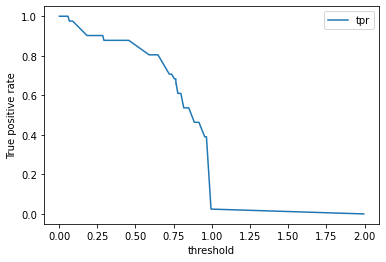

In [41]:
fig, ax = plt.subplots()
thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax)
ax.set_ylabel('True positive rate')

Lower threshold regime:
- identify everything as positive

High threshold:
- identify nothing as positive 

In [46]:
thresh_df['fpr'] = fpr
thresh_df.head()

,threshold,tpr,fpr
0,1.994631,0.000000,0.000000
1,0.994631,0.024390,0.000000
2,0.964606,0.390244,0.000000
3,0.953350,0.390244,0.028571
4,0.915328,0.463415,0.028571


<AxesSubplot:xlabel='threshold'>

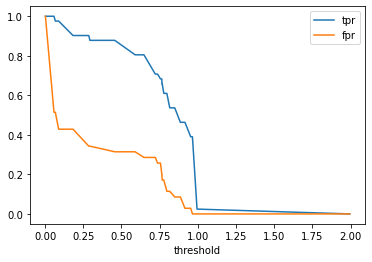

In [48]:
fig, ax = plt.subplots()
thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax)
thresh_df.plot(x = 'threshold', y = 'fpr', ax = ax)


In [ ]:
Want a good balance: 
    - false positive rate low

Probably more useful/used:
- plot ROC curve

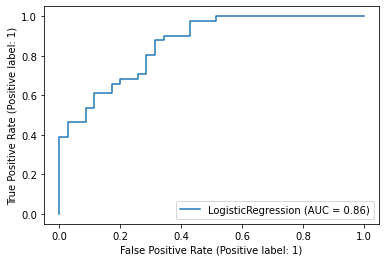

In [14]:
plot_roc_curve(hd_model, X_test_sc, y_test)

Cool. Lowering detection threshold:
-  If I raise significance level, lower detection threshold:
    - get more true positives
    - also get more false negatives
- Extreme case:
    - detects everything as positive class

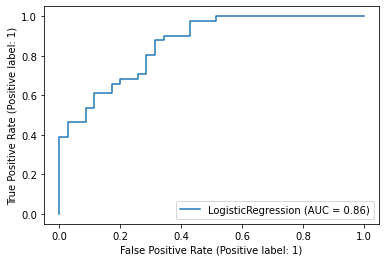

In [17]:
plot_roc_curve(hd_model, X_test_sc, y_test)

This can be used by practicioner:
- to decide where to operate Logistic Regression threshold
- decide what value of decision function $\textbf{w}^T x + b$ to separate class 0 vs. 1

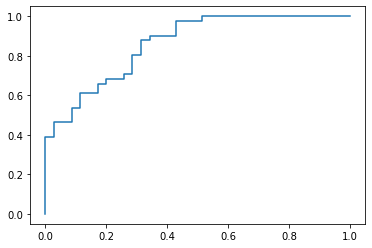

In [27]:
plt.plot(fpr, tpr)

Good balance between:
- true positive rate
- false positive rate

What does this have to do with model quality?
- Hope is that as we change threshold
- Can create models that typically have:
    - higher TPR vs. FPRs

Good model vs bad models

<center><img src = "Images/Roc_curves_better.png" /></center>

What affects the ROC curve?

That applet again.

http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Making good models are reflected in ROC curve structure:

- Use good distribution/function for data modeling
    - Model selection (logistic regression, tree model, etc.)
    - Feature Engineering

- Decrease model variance
    - Regularization
    - Get more data

Gives our ROC curve more downward L-shaped

#### ROC-AUC score

Gets the area under the ROC curve (AUC):
- Measure of model and/or data quality
- Bad model: AUC ~ 0.5 (area of triangle)
- Good model: AUC $\rightarrow$ 1

<center><img src = "Images/auc.png" width = 300 /></center>

<center><img src = "Images/Roc_curves_better.png" /></center>

In [68]:
from sklearn.metrics import roc_auc_score

In [69]:
# Extract the probabilitiy predictions for the "1" class (heart disease)
y_hat_hd = y_prob[:, 1]

roc_auc_score(y_test, y_hat_hd)

0.8606271777003485